In [29]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, interact
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal
import warnings

In [30]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Dummy data

In [31]:
torch.manual_seed(123)
train_x = torch.linspace(0, 1, 100)
# sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * np.sqrt(0.04)
test_x = torch.linspace(0, 1, 51)

# Plot function

In [32]:
def plot(pred, test_x, train_x=None, train_y=None):
    
    # Initialize plot
    fif, ax = plt.subplots(figsize=(4, 3))
    
    with torch.no_grad():

        # Get upper and lower confidence bounds
        lower, upper = pred.confidence_region()
        if train_x is not None and train_y is not None:
            # Plot training data
            ax.scatter(train_x.numpy(), train_y.numpy(), s=5, color="black", alpha=0.5)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), pred.mean.numpy(), 'C0')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        #ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    return ax

# Text book GP

In [33]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Prior:


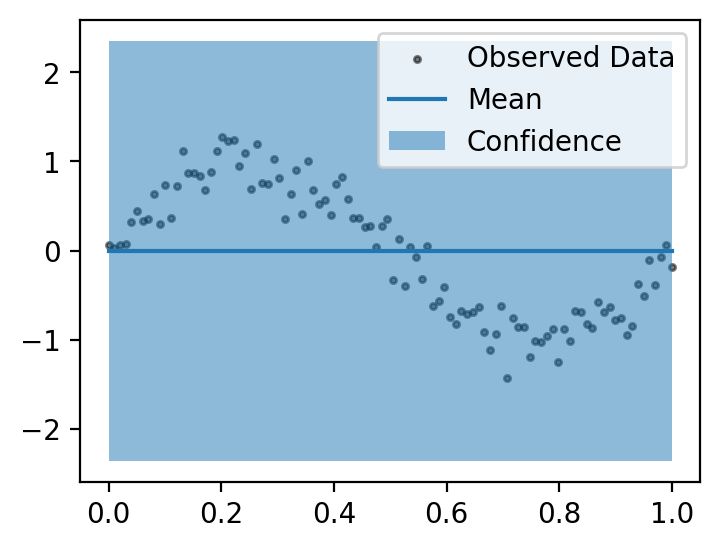

In [37]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model.forward(test_x)
    pred = likelihood(output)

print("Prior:")
plot(pred, train_x=train_x, train_y=train_y, test_x=test_x)
plt.show()

Posterior before training for the hyperparameters tunning:
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


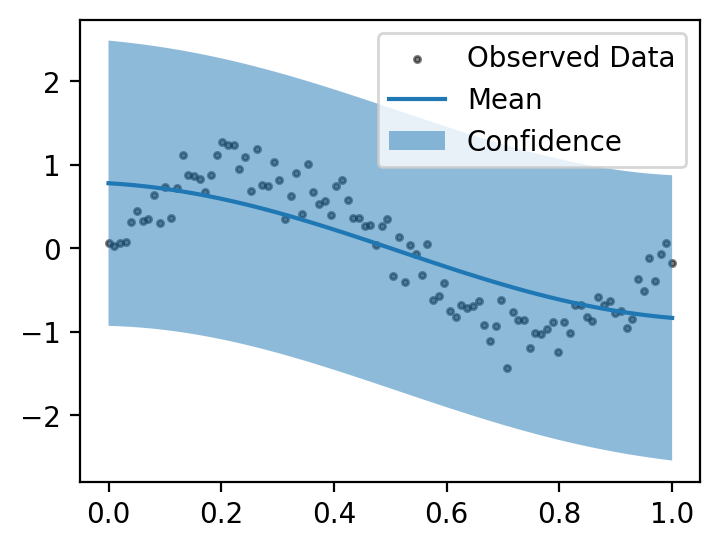

In [38]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

print("Posterior before training for the hyperparameters tunning:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    pred = likelihood(output)

plot(pred, train_x=train_x, train_y=train_y, test_x=test_x)
plt.show()

## Train

In [39]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

## After training

After training:
Parameter name: likelihood.noise_covar.raw_noise           value = -3.2192087173461914
Parameter name: mean_module.raw_constant                   value = -0.01518343761563301
Parameter name: covar_module.raw_outputscale               value = -0.4894760847091675
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.5281660556793213


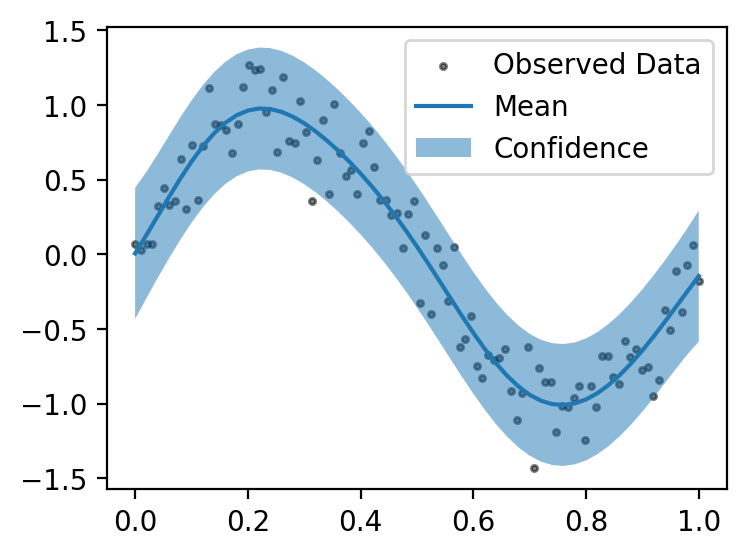

In [40]:
print("After training:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    observed_pred = likelihood(output)

plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x);

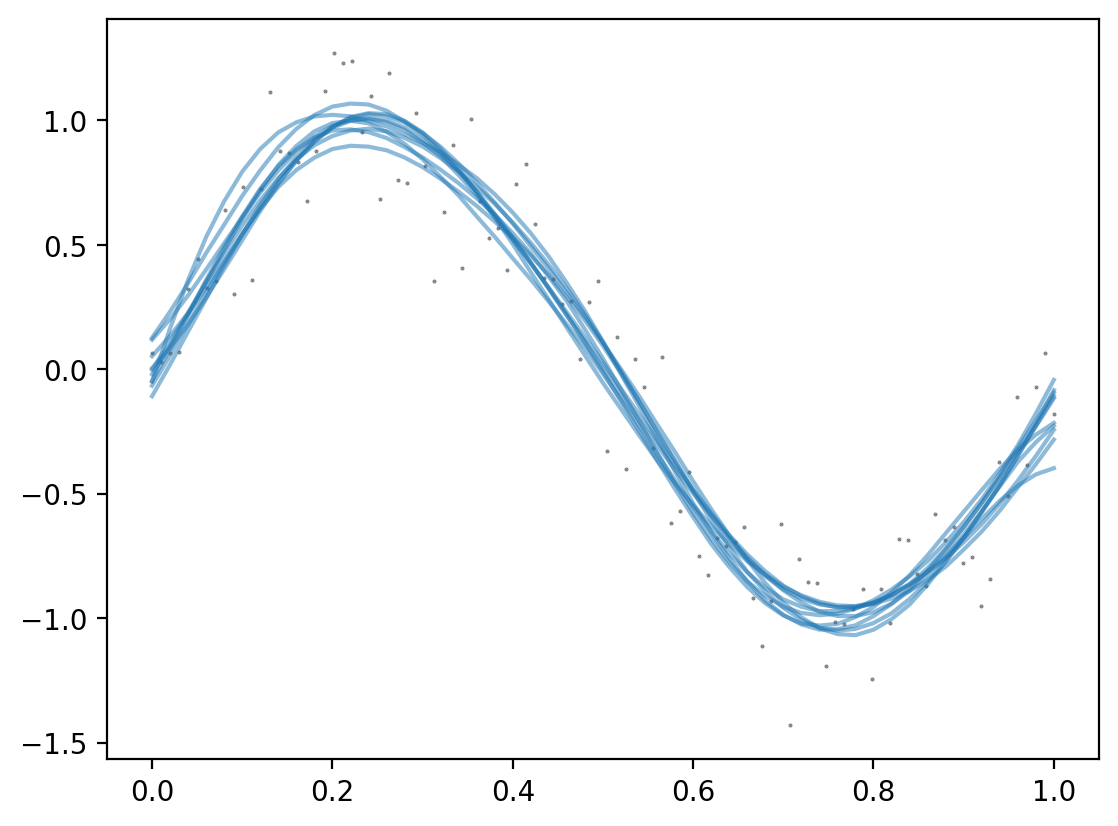

In [41]:
# Get into evaluation (predictive posterior) mode
model.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = model(test_x)
    pred = model.likelihood(output)
    
avg = pred.mean

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ys = model(test_x).sample(torch.Size((10, )))

fig, ax = plt.subplots()
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", alpha=0.5, s=0.2)
for y in ys:
    ax.plot(test_x.numpy(), y.numpy(), color="C0", alpha=0.5)